<a href="https://colab.research.google.com/github/LACLanthony/crimes_hotel/blob/main/hotels_crimes_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')
path = '/content/gdrive/MyDrive/data/'
csv1 = 'crime_2023.csv'
csv2 = 'hotels_geo.csv'

Mounted at /content/gdrive/


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic as GD
import folium
from folium.plugins import MarkerCluster


**The data and the packages have been loaded. I will now create two data frames: hotels and crimes.**



In [5]:
hotels = pd.read_csv(path+csv2)
crimes = pd.read_csv(path+csv1)

In [6]:
map = folium.Map(location=[30.2672, -97.733330], tiles='OpenStreetMap', zoom_start=15)

In [7]:
hotels.head(2)


,Unnamed: 0,index,hotel_name,address,city,state,zipcode,phone,lat,lng
0,0,0,Holiday Inn Express & Suites Austin Downtown -...,805 Neches St,Austin,TX,78701,(855) 862-4858,30.26931,-97.73732
1,1,1,Hotel Indigo Austin Downtown - University,810 Red River St,Austin,TX,78701,(737) 443-6259,30.26923,-97.73617


In [8]:
del hotels['Unnamed: 0']
del hotels['index']

In [9]:
crimes.head(2)

,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time,...,Y-coordinate,Latitude,Longitude,Location,Zip Codes,Single Member Council Districts,BOUNDARIES_single_member_districts,Zoning Review Cases_data,Neighborhood Planning Areas,Boundaries: City of Austin Council Districts
0,2023841087,THEFT,600,N,03/25/2023 12:10:00 PM,03/25/2023,1210,03/25/2023 07:42:00 PM,03/25/2023,1942,...,10058135.0,30.232975,-97.723787,"(30.23297487, -97.72378708)",3256.0,3.0,3.0,2947.0,94.0,1.0
1,2023841466,DISTURBANCE - OTHER,3401,N,03/25/2023 11:47:00 PM,03/25/2023,2347,03/25/2023 11:47:00 PM,03/25/2023,2347,...,10110544.0,30.376325,-97.685107,"(30.37632539, -97.68510677)",3642.0,4.0,9.0,1404.0,51.0,2.0


**Viewing the columns from each data frame, the crimes data frame can have some fields removed. However, it will be important that I keep the geo-location information on each of the data frames as they will be used in tandem later.**

In [10]:
print(crimes.columns)
print(hotels.columns)

Index(['Incident Number', 'Highest Offense Description',
       'Highest Offense Code', 'Family Violence', 'Occurred Date Time',
       'Occurred Date', 'Occurred Time', 'Report Date Time', 'Report Date',
       'Report Time', 'Location Type', 'Address', 'Zip Code',
       'Council District', 'APD Sector', 'APD District', 'PRA', 'Census Tract',
       'Clearance Status', 'Clearance Date', 'UCR Category',
       'Category Description', 'X-coordinate', 'Y-coordinate', 'Latitude',
       'Longitude', 'Location', 'Zip Codes', 'Single Member Council Districts',
       'BOUNDARIES_single_member_districts', 'Zoning Review Cases_data',
       'Neighborhood Planning Areas',
       'Boundaries: City of Austin Council Districts'],
      dtype='object')
Index(['hotel_name', 'address', 'city', 'state', 'zipcode', 'phone', 'lat',
       'lng'],
      dtype='object')


**The crimes data frame will now only have the following fields. Moving forward this is what the new crimes data frame will contain.**

In [11]:
crimes = crimes[['Highest Offense Description', 'Occurred Date Time', 'Location Type', 'Address', 'X-coordinate', 'Y-coordinate', 'Latitude',
       'Longitude', 'Location', 'APD Sector', 'APD District', 'Council District']]

**Here I will view the unique crimes that exist in the crimes data frame. This is important as some crimes are of similar type and may be easier to identify if stem of the crimes are kept. i.e. "Assault with a weapon" = "Assault"**

In [12]:
crimes['Highest Offense Description'].unique()

array(['THEFT', 'DISTURBANCE - OTHER', 'ROBBERY BY ASSAULT',
       'DOC DISCHARGE GUN - PUB ROAD', 'BURG OF RES - FAM/DATING ASLT',
       'FAMILY DISTURBANCE', 'AUTO THEFT', 'DWI  .15 BAC OR ABOVE',
       'POSS OF DRUG PARAPHERNALIA', 'ASSAULT BY THREAT FAM/DATING',
       'CRIMINAL TRESPASS', 'INTER EMERG PHONECALL FAM/DATE',
       'BURGLARY NON RESIDENCE', 'ASSAULT W/INJURY-FAM/DATE VIOL',
       'AGG ASSAULT', 'AGG ASSAULT FAM/DATE VIOLENCE', 'EVADING VEHICLE',
       'BURGLARY OF VEHICLE', 'DATING DISTURBANCE', 'ASSAULT WITH INJURY',
       'ASSAULT BY CONTACT FAM/DATING', 'DWI', 'EVADING / FOOT',
       'THEFT CATALYTIC CONVERTER', 'INTERFERE W PO SERVICE ANIMALS',
       'DAMAGE CITY VEHICLE', 'CRIMINAL MISCHIEF', 'TERRORISTIC THREAT',
       'DEADLY CONDUCT', 'VIOL STATE LAW - OTHER',
       'POSS CONTROLLED SUB/NARCOTIC', 'UNLAWFUL CARRYING WEAPON',
       'INTERFERING W/EMERG PHONE CALL', 'AGG ROBBERY/DEADLY WEAPON',
       'HARASSMENT', 'POSSESSION OF MARIJUANA',
       '

**The list of crimes will be sh

In [13]:
crime = ['ASSAULT','DWI', 'CRIMINAL MISCHIEF', 'GUN',
       'DEADLY CONDUCT', 'CRASH', 'POSSESSION', 'CRIMINAL TRESPASS','THEFT',
       'ROBBERY', 'BURGLARY', 'EVADING / VEHICLE PURSUIT','WEAPON', 'FIREARM',
       'CONTROLLED','VIOL CITY ORDINANCE - OTHER', 'ASSAULT BY CONTACT FAM/DATING',
       'HARASSMENT OF A PUBLIC SERVANT', 'EVADING VEHICLE', 'ARSON',
       'CRIMINAL TRESPASS/HOTEL','DAMAGE CITY PROP', 'TAMPERING WITH GOV RECORD',
       'INDECENCY WITH A CHILD/CONTACT', 'TERRORISTIC THREAT-MASS CASLTY',
       'THEFT CATALYTIC CONVERTER', 'CIVIL DISTURBANCE/DEMO','SEXUAL ASSAULT', 
       'EVADING','RAPE','RESISTING ARREST OR SEARCH','TRESPASS', 'BOMB THREAT',
       'PROSTITUTION','URINATING IN PUBLIC PLACE']

In [14]:
crimes['Crime_Type'] = [next(iter([y for y in crime if y in x]), np.nan) for x in crimes['Highest Offense Description']]

In [15]:
crimes.dropna(inplace=True)
crimes.reset_index(drop=True,inplace=True)

In [16]:
crimes.head(4)

,Highest Offense Description,Occurred Date Time,Location Type,Address,X-coordinate,Y-coordinate,Latitude,Longitude,Location,APD Sector,APD District,Council District,Crime_Type
0,THEFT,03/25/2023 12:10:00 PM,CONVENIENCE STORE,4405 E RIVERSIDE DR,3120615.0,10058135.0,30.232975,-97.723787,"(30.23297487, -97.72378708)",HE,4,3.0,THEFT
1,DOC DISCHARGE GUN - PUB ROAD,03/25/2023 04:53:00 PM,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,1900 RUNNING BROOK DR,3129523.0,10084997.0,30.306236,-97.693569,"(30.30623596, -97.69356946)",ID,4,4.0,GUN
2,DWI .15 BAC OR ABOVE,03/25/2023 02:42:00 AM,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,7600 N MOPAC EXPY NB,3112663.0,10103446.0,30.358038,-97.745623,"(30.35803848, -97.74562307)",BA,8,10.0,DWI
3,ASSAULT BY THREAT FAM/DATING,03/25/2023 06:09:00 AM,RESIDENCE / HOME,4805 PEACH GROVE RD,3118763.0,10044324.0,30.195130,-97.730673,"(30.19513014, -97.73067296)",FR,6,2.0,ASSAULT


**Now I will further distill down the crimes data frame and create an assaults data frame that will contain all the assaults.**

In [17]:
assaults = crimes[crimes['Crime_Type']=='ASSAULT']
assaults.reset_index(inplace=True)

In [18]:
assaults.head(4)

,index,Highest Offense Description,Occurred Date Time,Location Type,Address,X-coordinate,Y-coordinate,Latitude,Longitude,Location,APD Sector,APD District,Council District,Crime_Type
0,3,ASSAULT BY THREAT FAM/DATING,03/25/2023 06:09:00 AM,RESIDENCE / HOME,4805 PEACH GROVE RD,3118763.0,10044324.0,30.195130,-97.730673,"(30.19513014, -97.73067296)",FR,6,2.0,ASSAULT
1,6,ASSAULT W/INJURY-FAM/DATE VIOL,03/25/2023 09:07:00 PM,RESIDENCE / HOME,8116 WEST GATE BLVD,3087799.0,10044529.0,30.197648,-97.828643,"(30.19764792, -97.82864301)",FR,1,5.0,ASSAULT
2,8,AGG ASSAULT,03/25/2023 09:28:00 PM,PARKING /DROP LOT/ GARAGE,1610 E PARMER LN,3142929.0,10114985.0,30.387785,-97.648806,"(30.38778538, -97.64880627)",ED,6,7.0,ASSAULT
3,9,AGG ASSAULT FAM/DATE VIOLENCE,03/25/2023 09:16:00 PM,RESIDENCE / HOME,902 ROMERIA DR,3119511.0,10093736.0,30.330907,-97.724639,"(30.33090738, -97.72463856)",ID,7,7.0,ASSAULT


**Now I will feature engineer new fields. I will take the data from the crime data frame and add to the hotels data frame. The goal will be to find the mean distance of assaults that have occurred this year and how far they are from our hotels list.**
 

In [19]:
for index1, rows1 in hotels.iterrows():
  calc=[]
  for index2, rows2 in assaults.iterrows():
    calc.append(GD(rows1[['lat', 'lng']] , rows2[['Latitude', 'Longitude']]).miles)
  hotels.at[index1, 'Assault_mean_distance'] = np.mean(calc)
  hotels.at[index1, 'Assault_median_distance'] = np.median(calc)
  hotels.at[index1, 'Assault_max_distance'] = max(calc)
  hotels.at[index1, 'Assaults_min_distance']= min(calc)

**As you can now see there are new fields: "Assault_mean_distance", "Assault_median_distance", "Assault_max_distance", "Assaults_min_distance" these new fields are measured in miles and will be used for data analysis.**

In [20]:
hotels.head(4)

,hotel_name,address,city,state,zipcode,phone,lat,lng,Assault_mean_distance,Assault_median_distance,Assault_max_distance,Assaults_min_distance
0,Holiday Inn Express & Suites Austin Downtown -...,805 Neches St,Austin,TX,78701,(855) 862-4858,30.26931,-97.73732,5.294492,4.994135,16.288748,0.037396
1,Hotel Indigo Austin Downtown - University,810 Red River St,Austin,TX,78701,(737) 443-6259,30.26923,-97.73617,5.293358,4.979917,16.308455,0.057090
2,Holiday Inn Austin-Town Lake,20 N Interstate 35,Austin,TX,78701,(844) 335-0714,30.25396,-97.73690,5.481920,4.941585,17.329634,0.058792
3,Holiday Inn Austin Midtown,6000 Middle Fiskville Rd,Austin,TX,78752,(844) 276-6368,30.32327,-97.71028,5.892403,5.329325,16.330369,0.185042


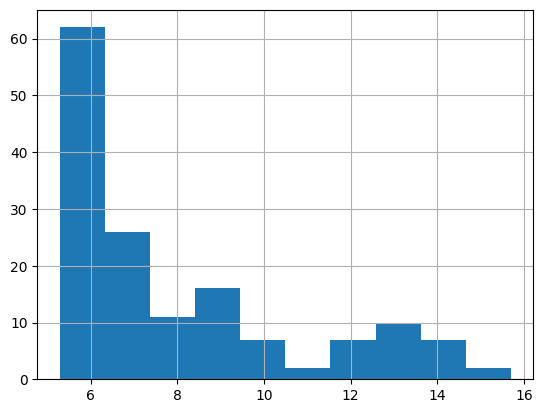

In [22]:
hotels['Assault_mean_distance'].hist()
plt.show()

**We can see that the hotels in our data set tend to be 6 miles on average from Assaults that have taken place.**

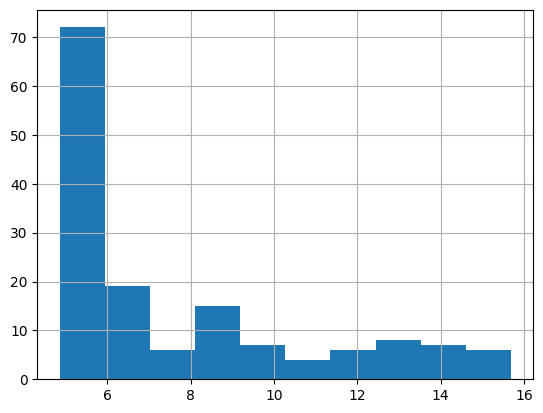

In [23]:
hotels['Assault_median_distance'].hist()
plt.show()

**Similarly the median seems to reflect the same findings as the mean. The median was checked to be certain their were no outliers that were skewing the findings.**

**The following are the top 10 hotels with the furthest average distance to an Assault.**

In [24]:
hotels.sort_values('Assault_mean_distance', ascending=False).head(10)

,hotel_name,address,city,state,zipcode,phone,lat,lng,Assault_mean_distance,Assault_median_distance,Assault_max_distance,Assaults_min_distance
147,La Quinta,1943 Medical Dr,Austin,TX,78734,(512) 263-1300,30.34594,-97.96877,15.699328,15.687439,24.635477,7.980911
33,La Hacienda RV Resort & Cottages,5220 Hudson Bend Rd,Austin,TX,78734,(512) 266-8001,30.41557,-97.92921,15.631366,15.483745,25.446335,4.138362
35,Mountain Star Lodge,3573 Ranch Road 620 S,Austin,TX,78738,(512) 263-2010,30.32210,-97.95459,14.581892,14.559340,23.124212,6.194132
116,"Home2 Suites by Hilton Austin/Cedar Park, TX",14022 N Highway 183,Austin,TX,78717,(512) 610-2107,30.47603,-97.80081,14.143745,14.839835,24.975659,0.274987
115,Aloft Hotels,14020 N Highway 183,Austin,TX,78717,(512) 219-0267,30.47587,-97.80071,14.132050,14.827676,24.964725,0.262974
17,Holiday Inn Express Round Rock - Austin N,301 W Louis Henna Blvd,Austin,TX,78728,(844) 476-1528,30.47957,-97.67737,14.028496,14.918430,26.377384,2.250663
119,TownePlace Suites by Marriott Austin Round Rock,541 Parker Dr,Austin,TX,78728,(512) 255-0600,30.47785,-97.68060,13.873737,14.775422,26.207924,2.220741
117,TownePlace Suites by Marriott Austin North/Lak...,13501 Lyndhurst St,Austin,TX,78717,(512) 257-0600,30.47499,-97.78258,13.761830,14.523040,24.943552,0.009445
118,Hilton Garden Inn Cedar Park Austin,13501 Lyndhurst St Bldg 1,Austin,TX,78717,(512) 506-8880,30.47499,-97.78258,13.761830,14.523040,24.943552,0.009445
114,Courtyard by Marriott,12833 Ranch Road 620 N,Austin,TX,78750,(512) 580-0083,30.46654,-97.80203,13.600680,14.226659,24.321037,0.270413


In [25]:
for index, rows in hotels.sort_values('Assault_mean_distance', ascending=False).head(10).iterrows():
  folium.CircleMarker(rows[['lat', 'lng']], popup=rows['hotel_name'], color='#00ff00').add_to(map)
map

**Graphically we see the hotels with green cricles are those that are furthest from Assaults taking place. These hotels are also further away from downtown Austin where it appears the majority of the assualts take place.**

**The following are the top 10 hotels with the nearest average distance to an Assault.**

In [26]:
hotels.sort_values('Assault_mean_distance', ascending=True).head(10)

,hotel_name,address,city,state,zipcode,phone,lat,lng,Assault_mean_distance,Assault_median_distance,Assault_max_distance,Assaults_min_distance
1,Hotel Indigo Austin Downtown - University,810 Red River St,Austin,TX,78701,(737) 443-6259,30.269230,-97.736170,5.293358,4.979917,16.308455,0.057090
0,Holiday Inn Express & Suites Austin Downtown -...,805 Neches St,Austin,TX,78701,(855) 862-4858,30.269310,-97.737320,5.294492,4.994135,16.288748,0.037396
127,HIE & SADUA,805 Neches St,Austin,TX,78701,(800) 345-8082,30.269310,-97.737320,5.294492,4.994135,16.288748,0.037396
31,DoubleTree by Hilton Hotel Austin - University...,1617 N Interstate 35,Austin,TX,78702,(512) 479-4000,30.277090,-97.729270,5.295663,4.904306,15.874253,0.082716
123,Omni Austin Hotel Downtown,700 San Jacinto Blvd,Austin,TX,78701,(512) 476-3700,30.269158,-97.739649,5.302741,5.001163,16.270860,0.044921
44,Omni Austin Hotel Downtown,700 San Jacinto At 8th Street,Austin,TX,78701,(512) 476-3700,30.268510,-97.740000,5.306380,4.997646,16.310486,0.036511
148,The Driskill - The Unbound Collection by Hyatt,604 Brazos St,Austin,TX,78701,(512) 439-1234,30.267980,-97.741370,5.317078,5.042906,16.330450,0.015936
41,Aloft Hotels,109 E 7th St,Austin,TX,78701,(512) 473-0000,30.268870,-97.742020,5.318829,5.051806,16.262873,0.028179
43,Azul Rooftop,310 E 5th St,Austin,TX,78701,(512) 792-5622,30.266310,-97.740290,5.320036,4.999793,16.455750,0.012123
42,The Stephen F Austin Royal Sonesta Hotel,701 Congress Ave,Austin,TX,78701,(512) 457-8800,30.269180,-97.742400,5.321050,5.060465,16.237614,0.029951


In [27]:
for index, rows in hotels.sort_values('Assault_mean_distance', ascending=True).head(10).iterrows():
  folium.CircleMarker(rows[['lat', 'lng']], popup=rows['hotel_name'], color='#ff0000').add_to(map)
map

**Shown Graphically by red circles we see that the hotels nearest the average Assault distance are those located downtown.**

In [30]:
assaults_geo = assaults[['Latitude', 'Longitude']]
assaults_geo.head(2)

,Latitude,Longitude
0,30.195130,-97.730673
1,30.197648,-97.828643


In [32]:
import folium.plugins as plugins


In [37]:
map.add_child(plugins.HeatMap(assaults_geo, radius=15))